In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
data_path = '../../data/postprocessed/INPUTSSA/'

mapping_table = {
    'gpuburn5min0': 'Single alternative',
    'gpuburn5min1': 'Couple alternative',
    'gpuburn5min2': 'Triple alternative',
    'gpuburn5min3': 'Quadruple alternative',
    'gpuburn5min4': 'Quintuple alternative',
    'gpuburn5min5': 'Sixtuple alternative',
    'gpuburn5minRandom': 'Original GPU-burn'
}

data_sheet = pd.DataFrame()
for csv_name in [file for file in os.listdir(data_path) if (('NN50Perc' in file or '5min' in file) and not 'telemetry' in file)]:
    csv_full_path = os.path.join(data_path, csv_name)
    print(csv_full_path)
    df = pd.read_csv(csv_full_path)
    df['Range'] = int(csv_name.split('_')[1].split('.')[0])
    df['App_name'] = mapping_table[csv_name.split('_')[0]]
    df['progress'] = (df['session_id'] - df['session_id'].min()) / (df['session_id'].max() - df['session_id'].min()) * 100
    # print(df[df.isna()])
    data_sheet=pd.concat([data_sheet, df], ignore_index=True)

location_mapping={
    'sm': 'Streaming Multiprocessor',
    'dram': 'Dynamic RAM',
    'l1tex': 'L1 Cache',
    'lts': 'L2 Cache',
    'smsp': 'Streaming Multiprocessor SubPartition'
}
data_sheet['HR_location'] = data_sheet['location'].map(location_mapping)

metric_event_mapping= {

    # Workload
    ## Compute
    'request_cycles_active': 'Number of cycles where the IDC processed requests from SM',
    'instruction_throughput': 'Instruction throughput',
    'inst_executed': 'Executed instructions',
    'inst_issued': 'Issued instructions',
    'sass_thread_inst_executed_op_fp64_pred_on': 'Instructions FP64',
    'sass_thread_inst_executed_op_integer_pred_on': 'Instructions Integers',

    ## Memory
    ### DRAM
    'bytes_read': 'Read Bytes',
    'bytes_write': 'Written bytes',

    ### L1 Cache
    't_sectors_pipe_lsu_mem_global_op_ld_lookup_hit': 'Global Memory Load Sectors – Cache Hit (per Thread Set via LSU)',
    't_sectors_pipe_lsu_mem_global_op_st_lookup_hit': 'Global Memory Store Sectors – Cache Hit (per Thread Set via LSU)',
    't_sectors_pipe_lsu_mem_global_op_red_lookup_hit': 'Global Memory Reduction – Cache Hit (per Thread Set via LSU)',
    't_sectors_pipe_lsu_mem_global_op_atom_lookup_hit': 'Global Memory Atomic – Cache Hit (per Thread Set via LSU)',
    't_sectors_pipe_lsu_mem_global_op_ld': ' Global Memory Load Sectors Served by L1 Cache (via LSU)',
    't_sectors_pipe_lsu_mem_global_op_st': ' Global Memory Store Sectors Served by L1 Cache (via LSU)',
    't_sectors_pipe_lsu_mem_global_op_red': 'Global Memory Reduction Sectors Served by L1 Cache (via LSU)',
    't_sectors_pipe_lsu_mem_global_op_atom': 'Global Memory Atomic Sectors Served by L1 Cache (via LSU)',
    
    ### L2 Cache
    't_sector_op_read_hit_rate': 'L2 hit rate by read instruction',
    't_sector_op_write_hit_rate': 'L2 hit rate by write instruction',

    # Stall
    ## Memory
    'warp_issue_stalled_imc_miss_per_warp_active': 'Warp Issue Stalls Due to IMC (Immediate Constant Cache) Misses per Active Warp ',
    'warp_issue_stalled_long_scoreboard_per_warp_active': 'Warp Issue Stalls Due to Long Scoreboard (Long Wait for Resource) per Active Warp',

    ## Controller
    'warp_issue_stalled_short_scoreboard_per_warp_active': 'Warp Issue Stalls Due to Short Scoreboard (Resource Wait) per Active Warp',
    'warp_issue_stalled_wait_per_warp_active': 'Warp Issue Stalls Due to Wait (Resource/Data Not Ready) per Active Warp',
    'warp_issue_stalled_not_selected_per_warp_active': 'Warp Issue Stalls Due to Not Being Selected per Active Warp',
    'warp_issue_stalled_sleeping_per_warp_active': 'Warp Issue Stalls Due to Sleeping per Active Warp',
    'warp_issue_stalled_membar_per_warp_active': 'Warp Issue Stalls Due to Membar per Active Warp',
    'warp_issue_stalled_barrier_per_warp_active': 'Warp Issue Stalls Due to Barrier per Active Warp',
    'warp_issue_stalled_dispatch_stall_per_warp_active': 'Warp Issue Stalls Due to Dispatch Stall per Active Warp',

    ## Throttle
    'warp_issue_stalled_drain_per_warp_active': 'Warp Issue Stalls Due to Drain (Memory/Resource Write Completion) per Active Warp',
    'warp_issue_stalled_lg_throttle_per_warp_active': 'Warp Issue Stalls Due to Large Unit Throttling (Resource Limitation) per Active Warp',
    'warp_issue_stalled_math_pipe_throttle_per_warp_active': 'Warp Issue Stalls Due to Math Pipe Throttling per Active Warp',
    'warp_issue_stalled_mio_throttle_per_warp_active': 'Warp Issue Stalls Due to MIO Throttling per Active Warp',
    'warp_issue_stalled_tex_throttle_per_warp_active': 'Warp Issue Stalls Due to Texture Throttling per Active Warp',

    ## Others
    'warp_issue_stalled_misc_per_warp_active': 'Warp Issue Stalls Due to Miscellaneous Issues per Active Warp',

}
data_sheet['metric_name'].unique()

data_sheet['HR_metric_name'] = data_sheet['metric_name'].map(metric_event_mapping)

df_l2 = data_sheet[data_sheet['HR_location']=='L2 Cache']
df_sm = data_sheet[data_sheet['HR_location']=='Streaming Multiprocessor']
df_smsp = data_sheet[data_sheet['HR_location']=='Streaming Multiprocessor SubPartition']
df_l1 = data_sheet[data_sheet['HR_location']=='L1 Cache']
df_dram = data_sheet[data_sheet['HR_location']=='Dynamic RAM']

dfs = {
    'L2 Cache': df_l2, 
    'Streaming Multiprocessor': df_sm, 
    'Streaming Multiprocessor SubPartition': df_smsp, 
    'L1 Cache': df_l1, 
    'Dynamic RAM': df_dram
    }

df_pivot_l2 = df_l2.pivot_table(
    index=["progress", "HR_location", "range_name", "Range", "App_name", 'rollup_operation', 'Post'],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_sm = df_sm.pivot_table(
    index=["progress", "HR_location", "range_name", "Range", "App_name", 'rollup_operation', 'Post'],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_smsp = df_smsp.pivot_table(
    index=["progress", "HR_location", "range_name", "Range", "App_name", 'rollup_operation', 'Post'],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_smsp['Memory Stall']=(df_pivot_smsp['Warp Issue Stalls Due to IMC (Immediate Constant Cache) Misses per Active Warp '] +\
              df_pivot_smsp['Warp Issue Stalls Due to Long Scoreboard (Long Wait for Resource) per Active Warp']) /2

df_pivot_smsp['Controller Stall']=(df_pivot_smsp['Warp Issue Stalls Due to Not Being Selected per Active Warp'] +\
                df_pivot_smsp['Warp Issue Stalls Due to Short Scoreboard (Resource Wait) per Active Warp'] +\
                df_pivot_smsp['Warp Issue Stalls Due to Wait (Resource/Data Not Ready) per Active Warp'] +\
                df_pivot_smsp['Warp Issue Stalls Due to Sleeping per Active Warp'] +\
                df_pivot_smsp['Warp Issue Stalls Due to Membar per Active Warp'] +\
                df_pivot_smsp['Warp Issue Stalls Due to Barrier per Active Warp'] ) /7

df_pivot_smsp['Throttle Stall']=(df_pivot_smsp['Warp Issue Stalls Due to Drain (Memory/Resource Write Completion) per Active Warp'] +\
                                df_pivot_smsp['Warp Issue Stalls Due to Large Unit Throttling (Resource Limitation) per Active Warp'] +\
                                df_pivot_smsp['Warp Issue Stalls Due to Math Pipe Throttling per Active Warp'] +\
                                df_pivot_smsp['Warp Issue Stalls Due to MIO Throttling per Active Warp'] +\
                                df_pivot_smsp['Warp Issue Stalls Due to Texture Throttling per Active Warp']) /5

df_pivot_l1 = df_l1.pivot_table(
    index=["progress", "HR_location", "range_name", "Range", "App_name", 'rollup_operation', 'Post'],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_l1['Global hit rate'] = (df_pivot_l1['Global Memory Atomic – Cache Hit (per Thread Set via LSU)']+ \
                                df_pivot_l1['Global Memory Load Sectors – Cache Hit (per Thread Set via LSU)']+\
                                df_pivot_l1['Global Memory Reduction – Cache Hit (per Thread Set via LSU)']+\
                                df_pivot_l1['Global Memory Store Sectors – Cache Hit (per Thread Set via LSU)']) / \
                                (df_pivot_l1[' Global Memory Load Sectors Served by L1 Cache (via LSU)']+ \
                                df_pivot_l1[' Global Memory Store Sectors Served by L1 Cache (via LSU)']+\
                                df_pivot_l1['Global Memory Atomic Sectors Served by L1 Cache (via LSU)']+\
                                df_pivot_l1['Global Memory Reduction Sectors Served by L1 Cache (via LSU)'])

df_pivot_dram = df_dram.pivot_table(
    index=["progress", "HR_location", "range_name", "Range", "App_name", 'rollup_operation', 'Post'],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

pivot_dfs = {
    'L2 Cache': df_pivot_l2, 
    'Streaming Multiprocessor': df_pivot_sm, 
    'Streaming Multiprocessor SubPartition': df_pivot_smsp, 
    'L1 Cache': df_pivot_l1, 
    'Dynamic RAM': df_pivot_dram
    }

../../data/postprocessed/INPUTSSA/gpuburn5min1_1.csv
../../data/postprocessed/INPUTSSA/gpuburn5min5_1.csv
../../data/postprocessed/INPUTSSA/gpuburn5min0_1.csv
../../data/postprocessed/INPUTSSA/gpuburn5min2_1.csv
../../data/postprocessed/INPUTSSA/gpuburn5min3_1.csv
../../data/postprocessed/INPUTSSA/gpuburn5min4_1.csv


## Cumulative analysis

In [4]:
a = pivot_dfs['L1 Cache'].groupby(by=["App_name"])[['Global hit rate']]\
    .mean()\
        .reset_index()

b = pivot_dfs['L2 Cache'].groupby(by=["App_name"])[[ 'L2 hit rate by read instruction','L2 hit rate by write instruction']]\
    .mean()\
        .reset_index()

c = pivot_dfs['Streaming Multiprocessor'].groupby(by=["App_name"])[[ 'Executed instructions','Instruction throughput', 'Issued instructions']]\
    .mean()\
        .reset_index()

d = pivot_dfs['Dynamic RAM'].groupby(by=["App_name"])[[ 'Read Bytes', 'Written bytes']]\
    .mean()\
        .reset_index()

e = pivot_dfs['Streaming Multiprocessor SubPartition'].groupby(by=["App_name"])[['Memory Stall', 'Controller Stall', 'Throttle Stall']]\
    .mean()\
        .reset_index()

merge_1 = pd.merge(a, b[['App_name', 'L2 hit rate by read instruction','L2 hit rate by write instruction']], on='App_name')
merge_2 = pd.merge(merge_1, c[['App_name', 'Executed instructions','Instruction throughput', 'Issued instructions']], on='App_name')
merge_3 = pd.merge(merge_2, d[['App_name','Read Bytes', 'Written bytes']], on='App_name')
final_merge = pd.merge(merge_3, e[['App_name', 'Memory Stall', 'Controller Stall', 'Throttle Stall']], on='App_name')
    

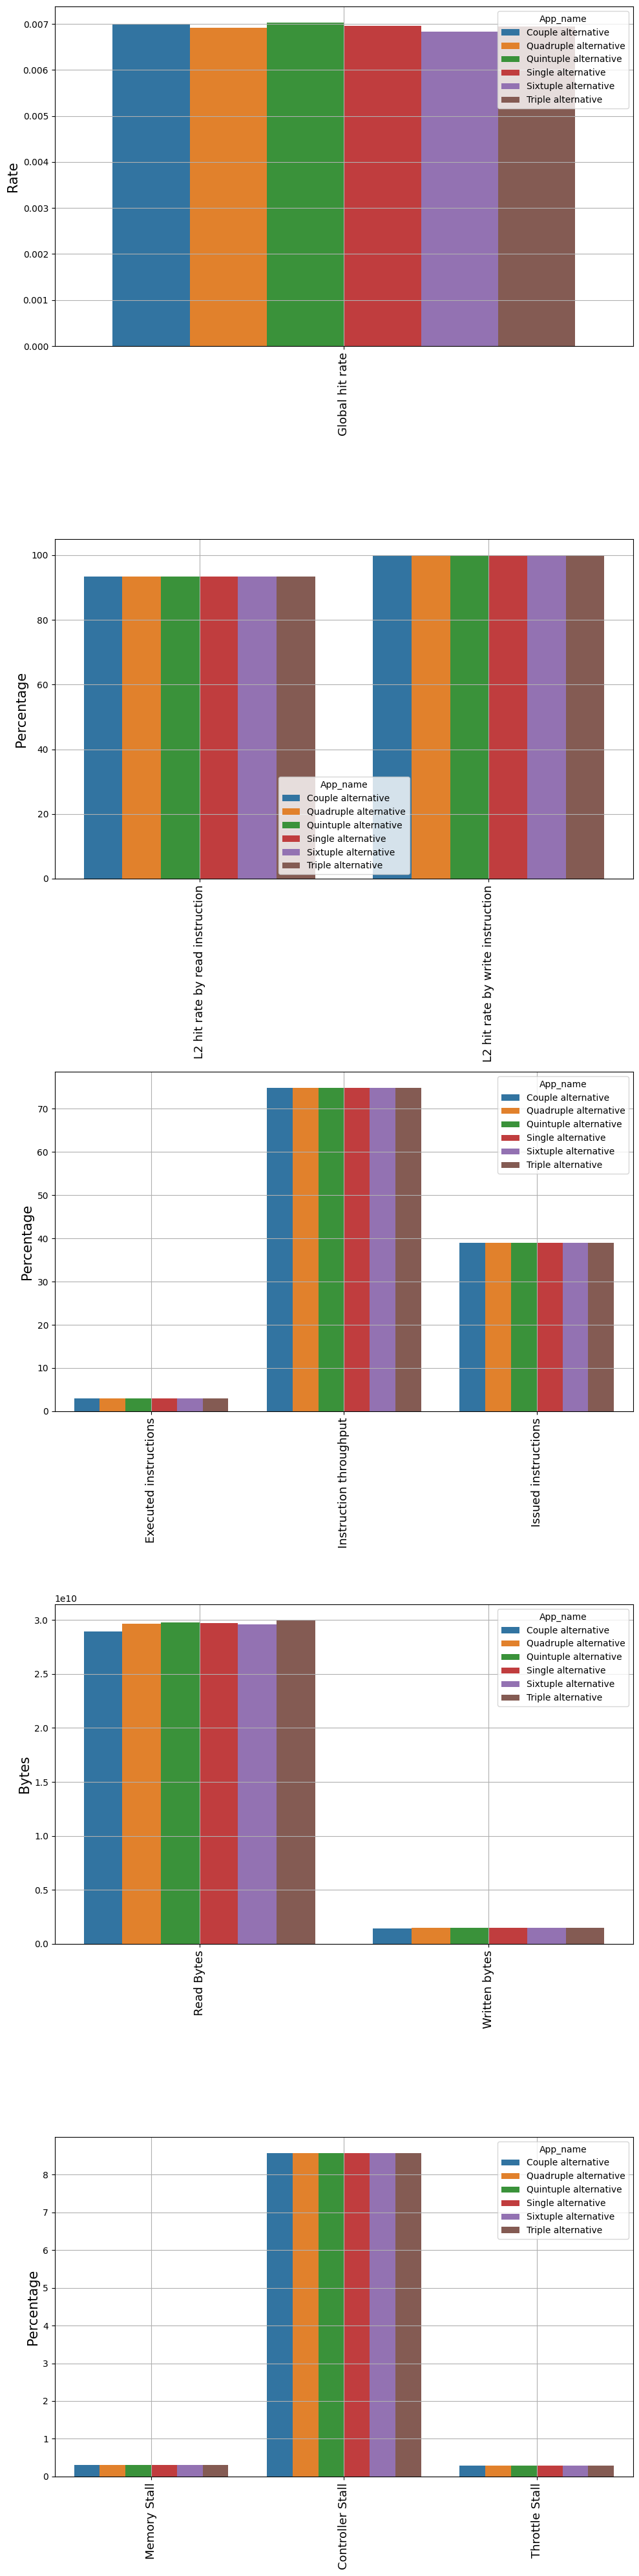

In [5]:
a_merge = pd.melt(
    a,
    id_vars='App_name',
    var_name='Metric',
    value_name='Value'
)

b_merge = pd.melt(
    b,
    id_vars='App_name',
    var_name='Metric',
    value_name='Value'
)

c_merge = pd.melt(
    c,
    id_vars='App_name',
    var_name='Metric',
    value_name='Value'
)

d_merge = pd.melt(
    d,
    id_vars='App_name',
    var_name='Metric',
    value_name='Value'
)

e_merge = pd.melt(
    e,
    id_vars='App_name',
    var_name='Metric',
    value_name='Value'
)

fig, ax = plt.subplots(5,1, figsize=(10,40))

# plt.yscale('log')
sns.barplot(data=a_merge, x='Metric', y='Value', hue='App_name', ax = ax[0])
ax[0].grid()
# ax[0].set_yscale('log')
ax[0].set_xlabel('Metric', fontsize=15)
ax[0].set_ylabel('Rate', fontsize=15)
ax[0].tick_params(axis='x', labelrotation=90, labelsize=13)
# ax[0].set_xticklabels([])
ax[0].set_xlabel('')

sns.barplot(data=b_merge, x='Metric', y='Value', hue='App_name', ax = ax[1])
ax[1].grid()
# ax[1].set_yscale('log')
ax[1].set_xlabel('Metric', fontsize=15)
ax[1].set_ylabel('Percentage', fontsize=15)
ax[1].tick_params(axis='x', labelrotation=90, labelsize=13)
# ax[1].set_xticklabels([])
ax[1].set_xlabel('')

sns.barplot(data=c_merge, x='Metric', y='Value', hue='App_name', ax = ax[2])
ax[2].grid()
# ax[2].set_yscale('log')
ax[2].set_xlabel('Metric', fontsize=15)
ax[2].set_ylabel('Percentage', fontsize=15)
ax[2].tick_params(axis='x', labelrotation=90, labelsize=13)
# ax[2].set_xticklabels([])
ax[2].set_xlabel('')

sns.barplot(data=d_merge, x='Metric', y='Value', hue='App_name', ax = ax[3])
ax[3].grid()
# ax[3].set_yscale('log')
ax[3].set_xlabel('Metric', fontsize=15)
ax[3].set_ylabel('Bytes', fontsize=15)
ax[3].tick_params(axis='x', labelrotation=90, labelsize=13)
# ax[3].set_xticklabels([])
ax[3].set_xlabel('')

sns.barplot(data=e_merge, x='Metric', y='Value', hue='App_name', ax = ax[4])
ax[4].grid()
# ax[4].set_yscale('log')
ax[4].set_xlabel('Metric', fontsize=15)
ax[4].set_ylabel('Percentage', fontsize=15)
ax[4].tick_params(axis='x', labelrotation=90, labelsize=13)
# ax[4].set_xticklabels([])
ax[4].set_xlabel('')

plt.tight_layout()

In [27]:
mapping_table = {
    'NN50Perclenet5': 'LeNet5',
    'NN50Percmnasnet05': 'MnasNet',
    'NN50Percmobilenetv2': 'MobileNetV2',
    'NN50Percresnet18': 'ResNet18',
    'gpuburn5min': 'GPU-burn'
}
data_path = '../../data/postprocessed/NCU/'
telemetry = pd.DataFrame()
for csv_name in [file for file in os.listdir(data_path) if (file.endswith('_telemetry.csv') and ('NN50Perc' in file or '5min' in file))]:
    csv_full_path = os.path.join(data_path, csv_name)
    print(csv_full_path)
    df = pd.read_csv(csv_full_path)
    df['Index'] = range(len(df))
    df['progress'] = df['Index'].transform(
        lambda x: 100 * (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0)
    df['Range'] = int(csv_name.split('_')[1].split('_')[0])
    df['App_name'] = mapping_table[csv_name.split('_')[0]]
    print(csv_name.split('_')[0])

    telemetry=pd.concat([telemetry, df], ignore_index=True)

../../data/postprocessed/NCU/NN50Perclenet5_1_telemetry.csv
NN50Perclenet5
../../data/postprocessed/NCU/NN50Percmobilenetv2_1_telemetry.csv
NN50Percmobilenetv2
../../data/postprocessed/NCU/NN50Percresnet18_1_telemetry.csv
NN50Percresnet18
../../data/postprocessed/NCU/gpuburn5min_1_telemetry.csv
gpuburn5min
../../data/postprocessed/NCU/NN50Percmnasnet05_1_telemetry.csv
NN50Percmnasnet05


In [11]:
telemetry.columns

Index(['timestamp_ns', 'gpu_index', 'name', 'temperature_C',
       'util_gpu_percent', 'util_mem_percent', 'mem_total_MB', 'mem_used_MB',
       'mem_free_MB', 'clock_sm_MHz', 'clock_mem_MHz', 'clock_graphics_MHz',
       'fan_speed_percent', 'power_draw_W', 'ecc_volatile_corrected',
       'ecc_volatile_uncorrected', 'ecc_aggregate_corrected',
       'ecc_aggregate_uncorrected', 'total_energy_mJ', 'Index', 'progress',
       'Range', 'App_name'],
      dtype='object')

Pendenza del transiente: 0.2181
Correlazione tra le variabili: 0.8763
p_value della regressione: 0.0000
std_err della stima: 0.0183


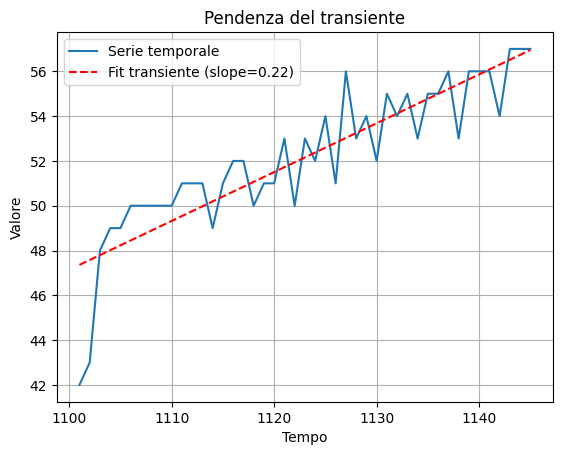

In [42]:
import matplotlib.pyplot as plt
import ruptures as rpt
from scipy.stats import linregress

signal = np.array(telemetry[telemetry['App_name']=='GPU-burn']['temperature_C'])
algo = rpt.Pelt(model="rbf").fit(signal)
# print(algo)
result = algo.predict(pen=20)
transient = telemetry[telemetry['App_name']=='GPU-burn']['temperature_C'].iloc[:result[0]]
slope, intercept, r_value, p_value, std_err = linregress(transient.index.values, transient.values)

print(f"Pendenza del transiente: {slope:.4f}")
print(f"Correlazione tra le variabili: {r_value:.4f}")
print(f"p_value della regressione: {p_value:.4f}")
print(f"std_err della stima: {std_err:.4f}")

plt.plot(transient.index.values, transient.values, label="Serie temporale")
plt.plot(transient.index.values, slope * transient.index.values + intercept, 'r--', label=f"Fit transiente (slope={slope:.2f})")
plt.legend()
plt.xlabel("Tempo")
plt.ylabel("Valore")
plt.title("Pendenza del transiente")
plt.grid(True)
plt.show()

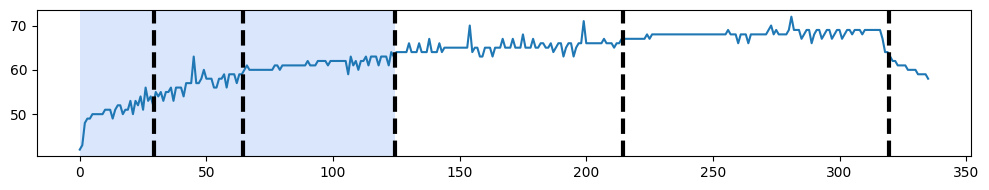

In [44]:
import matplotlib.pyplot as plt
import ruptures as rpt


# detection
signal=np.array(telemetry[telemetry['App_name']=='GPU-burn']['temperature_C'])
algo = rpt.Pelt(model="rbf").fit(signal)
print(algo)
result = algo.predict(pen=10)
bkps =[125]
# display
rpt.display(signal, bkps, result)
plt.show()